# AdaBoost

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def load_simp_data():
    dataset = np.array([[1, 2.1], [2, 1.1], [1.3, 1], [1, 1], [2, 1]])
    labels = np.array([1, 1, -1, -1, 1], dtype=float)
    return dataset, labels

In [5]:
dataset, labels = load_simp_data()

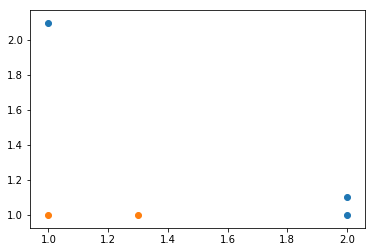

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(dataset[labels == 1, 0], dataset[labels == 1, 1])
ax.scatter(dataset[labels == -1, 0], dataset[labels == -1, 1])
plt.show()

## create a simple decision tree with just a single layer

In [314]:
class single_tree():
    #def __init__(self):
    def train(self, dataset, labels, D):
        m, n = dataset.shape
        self.model = {}
        self.D = D
        min_error = np.inf
        steps = 10
        #find a best index, threshold, tres_ineq to classify the dataset
        for i in range(n):
            min_value = dataset[:, i].min()
            max_value = dataset[:, i].max()
            step_size = (max_value - min_value)/steps
            for j in range(-1, steps+1):
                threshold = min_value + j*step_size
                for thres_ineq in ['lt', 'gt']:
                    predict_labels = np.ones(m)
                    if thres_ineq == 'lt':
                        predict_labels[dataset[:, i] <= threshold] = -1.0
                    else:
                        predict_labels[dataset[:, i] > threshold] = -1.0
                    err_arr = (predict_labels != labels)
                    weight_err = np.matmul(D, err_arr.T)
                    #print('index: ', i, 'threshold: ', threshold, \
                     #     'thres_ineq: ', thres_ineq, 'error rate: ', weight_err)
                    if weight_err < min_error:
                        min_error = weight_err
                        self.error = min_error
                        self.model['index'] = i
                        self.model['threshold'] = threshold
                        self.model['ineq'] = thres_ineq
                        self.best_predict = predict_labels.copy()
    
    def predict(self, x):
        m, n = x.shape
        predict_labels = np.ones(m)
        if self.model['ineq'] == 'lt':
            predict_labels[x[:, self.model['index']] <= self.model['threshold']] = -1
        else:
            predict_labels[x[:, self.model['index']] > self.model['threshold']] = -1
        return predict_labels
    
    def labels_amend(self, labels):
        return np.sign(labels)

In [315]:
D = np.ones(len(labels))/(len(labels))
tree = single_tree()
tree.train(dataset, labels, D)
tree_test = []
tree_test.append(tree)

In [316]:
tree_test[0].best_predict

array([-1.,  1., -1., -1.,  1.])

In [317]:
acc_rate = np.ones(5)

In [318]:
(tree_test[0].best_predict == labels)

array([False,  True,  True,  True,  True], dtype=bool)

In [319]:
acc_rate[tree_test[0].best_predict == labels] = -1
acc_rate

array([ 1., -1., -1., -1., -1.])

In [320]:
tree.predict(np.array([[-1, 1]]))

array([-1.])

## Create a adaboost model

In [382]:
class adaboost():
    def train(self, model, dataset, labels, num = 50):
        self.weak_model = []
        m, _ = dataset.shape
        D = np.ones(m)/m #init the weight of every sample
        acc_predict = np.zeros(m)
        
        for i in range(num):
            weak_model = model()
            #print('D:', D)
            weak_model.train(dataset, labels, D)
            # alpha = ln((1-error)/error)/2, alpha is the weight of every model's predict, 
            # and we also use alpha to update D
            alpha = 0.5 * np.log((1-weak_model.error)/max(weak_model.error, 1e-16))
            self.weak_model.append({'model': weak_model, 'alpha': alpha})
            
            '''
            updata weight 
            if the predict is right of the sample:
                D_temp = D(t) * exp(-alpha)
            else:
                D_temp = D(t) * exp(alpha)
            D(t+1) = D_temp / D_temp.sum()
            '''
            D_rate = np.ones(m)
            D_rate[weak_model.best_predict == labels] = -1
            D_rate = D * np.exp(D_rate * alpha)
            D = D_rate / D_rate.sum()
            
            # claculate the error rate
            acc_predict += alpha * weak_model.best_predict
            self.error_rate = (weak_model.labels_amend(acc_predict) != labels).mean()
            #print('total error rate:', self.error_rate)
            self.classer_num = i + 1
            if self.error_rate == 0 : break
    
    
    def predict(self, x):
        m, _ = x.shape
        acc_predict = np.zeros(m)
        for i in range(self.classer_num):
            predict_single = self.weak_model[i]['model'].predict(x)
            acc_predict += self.weak_model[i]['alpha'] * predict_single
        return self.weak_model[i]['model'].labels_amend(acc_predict)
        

In [322]:
boost_model = adaboost()

In [323]:
boost_model.train(single_tree, dataset, labels, 10)

total error rate: 0.2
total error rate: 0.2
total error rate: 0.0


In [324]:
boost_model.predict(dataset) == labels

array([ True,  True,  True,  True,  True], dtype=bool)

## Use adaboost to train horse Colic dataset

In [325]:
f = open('horseColicTraining2.txt')
lines = f.readlines()

In [326]:
lines[0]

'2.000000\t1.000000\t38.500000\t66.000000\t28.000000\t3.000000\t3.000000\t0.000000\t2.000000\t5.000000\t4.000000\t4.000000\t0.000000\t0.000000\t0.000000\t3.000000\t5.000000\t45.000000\t8.400000\t0.000000\t0.000000\t-1.000000\n'

In [327]:
def load_dataset(filename):
    f = open(filename)
    lines = f.readlines()
    dataset = []
    for line in lines:
        dataset.append(line.strip().split('\t'))
    dataset = np.array(dataset)
    labels = dataset[:, -1].astype(float)
    dataset = dataset[:, :-1].astype(float)
    return dataset, labels

In [328]:
train_datas, train_labels = load_dataset('horseColicTraining2.txt')

In [329]:
train_datas.shape

(299, 21)

In [353]:
horse_colic_boost = adaboost()
horse_colic_boost.train(single_tree, train_datas, train_labels, 100)

total error rate: 0.284280936455
total error rate: 0.284280936455
total error rate: 0.247491638796
total error rate: 0.247491638796
total error rate: 0.254180602007
total error rate: 0.240802675585
total error rate: 0.240802675585
total error rate: 0.220735785953
total error rate: 0.247491638796
total error rate: 0.230769230769
total error rate: 0.240802675585
total error rate: 0.214046822742
total error rate: 0.227424749164
total error rate: 0.217391304348
total error rate: 0.220735785953
total error rate: 0.217391304348
total error rate: 0.224080267559
total error rate: 0.224080267559
total error rate: 0.230769230769
total error rate: 0.224080267559
total error rate: 0.214046822742
total error rate: 0.207357859532
total error rate: 0.224080267559
total error rate: 0.224080267559
total error rate: 0.214046822742
total error rate: 0.220735785953
total error rate: 0.204013377926
total error rate: 0.207357859532
total error rate: 0.210702341137
total error rate: 0.217391304348
total erro

In [352]:
horse_colic_boost.error_rate

0.19063545150501673

In [373]:
#use test data
test_datas, test_labels = load_dataset('horseColicTest2.txt')
(horse_colic_boost.predict(test_datas) == test_labels).mean()

0.77611940298507465

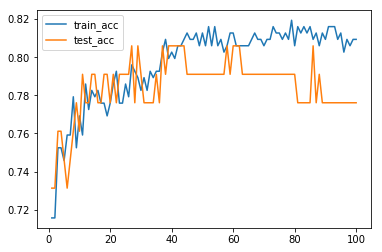

In [387]:
train_acc = []
test_acc = []
horse_colic_boost = adaboost()
step = 100
for i in range(1, step+1):
    horse_colic_boost.train(single_tree, train_datas, train_labels, i)
    train_acc.append(1 - horse_colic_boost.error_rate)
    test_acc.append((horse_colic_boost.predict(test_datas) == test_labels).mean())
    #print(i)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(1, step+1), train_acc, label='train_acc')
ax.plot(range(1, step+1), test_acc, label='test_acc')
plt.legend()
plt.show()

## train pima dataset

In [388]:
import pandas as pd
pima_dataset = pd.read_csv('pima-indians-diabetes.data.csv', header=None )
pima_labels = pima_dataset[8]
del pima_dataset[8]
pima_dataset = np.array(pima_dataset)
pima_labels = np.array(pima_labels)

In [389]:
pima_labels[pima_labels == 0] = -1

In [390]:
pima_boost = adaboost()
pima_boost.train(single_tree, pima_dataset, pima_labels, 100)

In [391]:
pima_boost.error_rate

0.20442708333333334